<a href="https://colab.research.google.com/github/Janakisrija/64018_jmadduku/blob/main/Assignment_2/Assignment2_AML_Convnet_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Assignment 2 - Deep learning for computer vision**

### “Deep learning for computer vision,” convents can be used successfully to classify images. Specifically, consider the Cats & Dogs example. There were two broad approaches to classifying Cats & Dogs using convnets: Training a network from scratch, versus using a pretrained convnet. While small datasets can lead to overfitting, thus making training a network for prediction more difficult, you also saw several techniques to reduce overfitting, and these include data augmentation and regularization.
### In this assignment, you will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet.

###The training archive contains 25,000 images of dogs and cats. 

### Downloading the data

 Uploading the json file from kaggle to access the data from dogs-vs-cats dataset.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srijasreeshti","key":"5d42f89bd6b8bb174e57573a57907558"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:24<00:00, 50.2MB/s]
100% 812M/812M [00:25<00:00, 33.4MB/s]


In [4]:
!unzip -qq dogs-vs-cats

In [5]:
!unzip -qq test1.zip

In [6]:
!unzip -qq train.zip

In [7]:
#shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
#shutil.rmtree("./test1", ignore_errors=True)
#shutil.rmtree("./train", ignore_errors=True)


## Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?


### Here the training sample is of 1000 images
#### Test Accuracy - 70.1%

#### Training Accuraccy - 99.3%

#### Validation Accuracy - 75.6%

**Copying images to training, validation, and test directories**

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

##Data Preprocessing
####Converting the data into Preprocessed flaoting point tensors before being fed into the model.
####Since the data is in the JPEG file format,here are the steps of  preprocessing:
####1.Read the pictures
####2.Convert JPEG content into RGB grid of pixels
####3. Convert RGB grid of pixels into floating point tensors
####4. Resize them
####5. Make them into batches

**Using `image_dataset_from_directory` to read images**

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a datset instance from NumPy array of random numbers of 1000 samples and each sample of vector size 16

In [10]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [11]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


Batching the data into batches of size 32

In [12]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [13]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


##Building the model

**Instantiating a small convnet for dogs vs. cats classification**


In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Configuring the model for training**

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a `Dataset`**

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 21s 122ms/step - loss: 0.6951 - accuracy: 0.5155 - val_loss: 0.6903 - val_accuracy: 0.5060
Epoch 2/30
63/63 [==============================] - 7s 109ms/step - loss: 0.6882 - accuracy: 0.5440 - val_loss: 0.6736 - val_accuracy: 0.5980
Epoch 3/30
63/63 [==============================] - 7s 109ms/step - loss: 0.6767 - accuracy: 0.5710 - val_loss: 0.6614 - val_accuracy: 0.5990
Epoch 4/30
63/63 [==============================] - 7s 108ms/step - loss: 0.6552 - accuracy: 0.5980 - val_loss: 0.6239 - val_accuracy: 0.6520
Epoch 5/30
63/63 [==============================] - 8s 129ms/step - loss: 0.6146 - accuracy: 0.6705 - val_loss: 0.6220 - val_accuracy: 0.6500
Epoch 6/30
63/63 [==============================] - 7s 111ms/step - loss: 0.5951 - accuracy: 0.6820 - val_loss: 0.5824 - val_accuracy: 0.7010
Epoch 7/30
63/63 [==============================] - 7s 109ms/step - loss: 0.5613 - accuracy: 0.7075 - val_loss: 0.5752 - val_accuracy: 0.7150
Epoch

**Displaying curves of loss and accuracy during training**

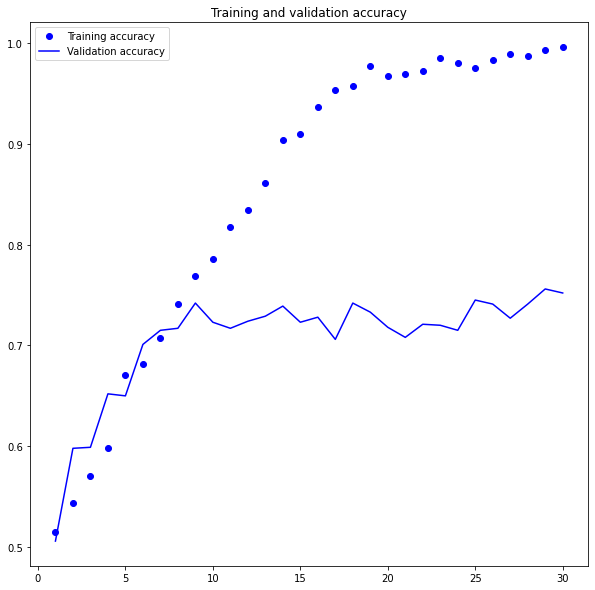

<Figure size 432x288 with 0 Axes>

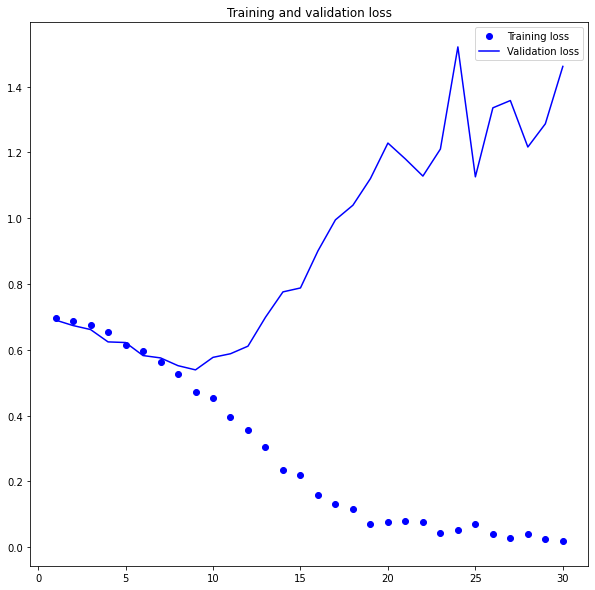

In [19]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 44ms/step - loss: 0.5958 - accuracy: 0.7010
Test accuracy: 0.701


# Q2.  Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

#### Test Accuracy - 81.1%

#### Training Accuraccy - 89.05%

#### Validation Accuracy - 82.6% 


**Define a data augmentation stage to add to an image model**

In [21]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

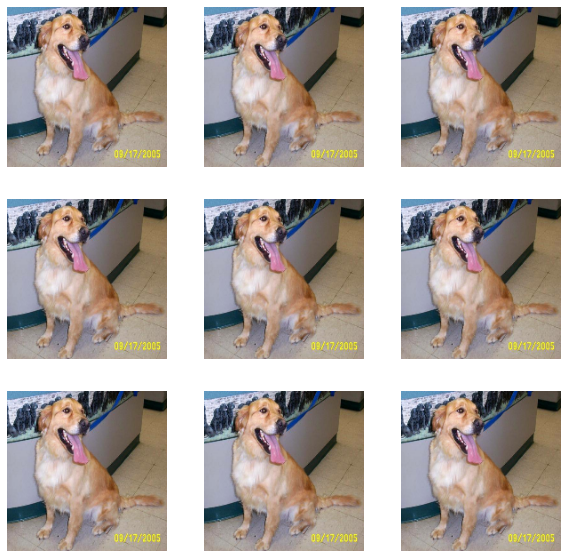

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 116ms/step - loss: 0.6953 - accuracy: 0.5035 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6933 - accuracy: 0.5105 - val_loss: 0.6900 - val_accuracy: 0.5810
Epoch 3/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6897 - accuracy: 0.5665 - val_loss: 0.6910 - val_accuracy: 0.5270
Epoch 4/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6715 - accuracy: 0.5855 - val_loss: 0.6695 - val_accuracy: 0.5930
Epoch 5/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6581 - accuracy: 0.6255 - val_loss: 0.7011 - val_accuracy: 0.5630
Epoch 6/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6562 - accuracy: 0.6060 - val_loss: 0.6609 - val_accuracy: 0.5850
Epoch 7/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6485 - accuracy: 0.6250 - val_loss: 0.6679 - val_accuracy: 0.5800
Epoch 

**Evaluating the model on the test set**

In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 43ms/step - loss: 0.4360 - accuracy: 0.8110
Test accuracy: 0.811


# Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.




#### Test Accuracy - 73.9%

#### Training Accuraccy - 77.5%

#### Validation Accuracy - 78.1%

#### In this step 3, I used 2000 training samples with validation and test sets with 500 samples. I noticed that the test accuracy is better when the training sample is 1500 images than 1000 and 2000 training samples. 
### Training accuracy is better when there are 1000 training samples.

### Increasing the training sample to 2000, keeping the Validation and test sets the same as before which is 500 samples.

In [27]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

**Defining a new convnet with increased training samples,image augmentation and dropout**

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 116ms/step - loss: 0.6958 - accuracy: 0.5020 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6934 - accuracy: 0.4845 - val_loss: 0.6930 - val_accuracy: 0.5420
Epoch 3/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6936 - accuracy: 0.5090 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6928 - accuracy: 0.5115 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 7s 113ms/step - loss: 0.6933 - accuracy: 0.5115 - val_loss: 0.6890 - val_accuracy: 0.5580
Epoch 6/50
63/63 [==============================] - 7s 113ms/step - loss: 0.6941 - accuracy: 0.5035 - val_loss: 0.6924 - val_accuracy: 0.5180
Epoch 7/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6935 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 

In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 44ms/step - loss: 0.5283 - accuracy: 0.7390
Test accuracy: 0.739


# Summary for Q1, Q2 and Q3

---



### I started by training a small convnet on the 1,000 training samples, without any optimization to set a baseline which got us a classification accuracy in the vicinity of 70%. The main issue that was identified was overfitting. 

###Then I introduced data augmentation and other optimization techniques like earlystopping(which determines the optimal number of epochs), Regularization and Dropout. By using data augmentation, we improved the model to reach an accuracy of 80%.

###Then I tried to find the optimal training sample to increase classification accuracy.

###It was observed by the manipulation of the training sample and usage of other optimization techniques that the best ways prevent overfitting are as follows
### 1. **Getting more training samples** - Increasing the training sample is not always possible. One way of optimally using the less training samples is Data Augmentation.
### 2. **Reducing the capacity of the network** - It was observed that reducing the size of the model i.e the number of learnable parameters in the model which is essentially the  number of layers  and the number of units in layers, considerably prevents overfitting
### 3. **Adding weight regularization** - Putting constraint on the complexity of a network by forcing the weights  to take only small values, which helps in regularizing the distribution of the weight values which in turns helps in preventing or minimizing overfitting
### 4. **Adding dropout** - Zeroing out a number of output features of the layer during training, helps in minimizing overfitting as well. The dropout rate is the fraction of the features that are zeroed out.


---




##Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

#### Using a pretrained model to apply deep learning to tiny image datasets is a highly effective method. A pretrained model is one that has been trained earlier on a big dataset, usually for a large-scale image classification problem.

#### We'll utilize a huge convnet trained on the ImageNet dataset in this scenario (1.4 million labeled images and 1,000 different classes). We'll utilize the VGG16 architecture, although there are a variety of other designs to choose from, including VGG, ResNet, Inception, Xception, and so on.

#### Many other image-classification models (all pretrained on the ImageNet dataset) are available as part of keras.applications:
#### 1. Xception
#### 2. ResNet
#### 3. MobileNet
#### 4. EfficientNet
#### 5. DenseNet etc.


### Feature extraction with a pretrained model

#### Feature extraction is the process of extracting important features from new samples using the representations acquired by a previously trained model (in our instance, ImageNet). These characteristics are then fed into a new classifier that has been trained from the ground up.

**Instantiating the VGG16 convolutional base**

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Feature extraction without data augmentation using a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [34]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [35]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 19ms/step - loss: 14.3940 - accuracy: 0.9325 - val_loss: 3.0523 - val_accuracy: 0.9750
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 4.3834 - accuracy: 0.9740 - val_loss: 3.4845 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3.7444 - accuracy: 0.9760 - val_loss: 10.6007 - val_accuracy: 0.9520
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.0636 - accuracy: 0.9900 - val_loss: 4.9104 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 1.0734 - accuracy: 0.9910 - val_loss: 4.1645 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.9396 - accuracy: 0.9920 - val_loss: 5.0328 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.2768 - accuracy: 0.9975 - val_loss: 6.3499 - val_accuracy: 0.9720
Epoch 8/20
63/63

**Plotting the results**

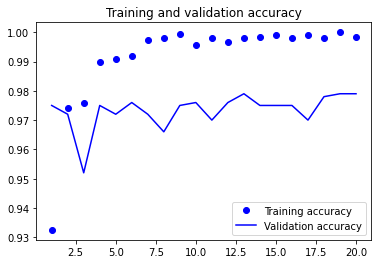

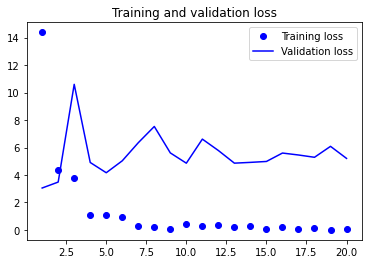

In [36]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Feature extraction with data augmentation using a pretrained model

**Instantiating and freezing the VGG16 convolutional base**

In [37]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [38]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [39]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 25s 363ms/step - loss: 14.6875 - accuracy: 0.9010 - val_loss: 3.8363 - val_accuracy: 0.9740
Epoch 2/50
63/63 [==============================] - 21s 336ms/step - loss: 8.1183 - accuracy: 0.9340 - val_loss: 4.1166 - val_accuracy: 0.9690
Epoch 3/50
63/63 [==============================] - 22s 343ms/step - loss: 5.3061 - accuracy: 0.9620 - val_loss: 2.7414 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 21s 336ms/step - loss: 4.5464 - accuracy: 0.9570 - val_loss: 3.3849 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 21s 336ms/step - loss: 3.5354 - accuracy: 0.9680 - val_loss: 4.1625 - val_accuracy: 0.9730
Epoch 6/50
63/63 [==============================] - 21s 335ms/step - loss: 3.7663 - accuracy: 0.9670 - val_loss: 4.6306 - val_accuracy: 0.9720
Epoch 7/50
63/63 [==============================] - 21s 335ms/step - loss: 2.6937 - accuracy: 0.9720 - val_loss: 4.2707 - val_accuracy: 0.975

**Evaluating the model on the test set**

In [42]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 213ms/step - loss: 2.5717 - accuracy: 0.9750
Test accuracy: 0.975


### A pretrained VGG16 model with Fine-tuning 

#### Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand.

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 25s 372ms/step - loss: 0.6659 - accuracy: 0.9860 - val_loss: 1.7363 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 23s 369ms/step - loss: 0.4491 - accuracy: 0.9855 - val_loss: 1.5180 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 23s 367ms/step - loss: 0.2483 - accuracy: 0.9915 - val_loss: 1.7975 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 23s 363ms/step - loss: 0.2431 - accuracy: 0.9885 - val_loss: 1.9949 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 24s 370ms/step - loss: 0.4183 - accuracy: 0.9895 - val_loss: 1.3940 - val_accuracy: 0.9830
Epoch 6/30
63/63 [==============================] - 24s 369ms/step - loss: 0.4231 - accuracy: 0.9915 - val_loss: 1.3773 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 23s 365ms/step - loss: 0.1950 - accuracy: 0.9945 - val_loss: 1.4737 - val_accuracy: 0.9820

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 212ms/step - loss: 1.3501 - accuracy: 0.9750
Test accuracy: 0.975


## Summary

### Using a Pre-trained model without Augmentation

#### We reach a validation accuracy of about 97.70% which is better than what we achieved while training the small model from scratch. This won’t always be the case when you use pretrained features.
#### However, the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

### Using a Pre-trained model without Augmentation

#### A model’s accuracy always depends on the set of samples one evaluates it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets. because of this reason, Pretrained model With Augmentation, there was just a minor increase in the accuracy from 97.70% to 98.10%.

### Using Pretrained model with fine tuning
#### Here, we get a test accuracy of 98.0%

### These accuracy results might change within one percentage range of point.